## Classification Using Pyspark

### Pyspark Initializasing

In [1]:
# to make pyspark importable as a regular library
import findspark
findspark.init()

import pyspark

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

#initializasing SparkSession for creating Spark DataFrame
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

### Load Libraries

In [2]:
# Data Frame spark profiling 
from pyspark.sql.types import IntegerType, StringType, DoubleType, ShortType, DecimalType
import pyspark.sql.functions as func
from pyspark.sql.functions import isnull
from pyspark.sql.functions import isnan, when, count, col, round
from pyspark.sql.functions import mean
from pyspark.sql.types import Row
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf


# Pandas DF operation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import array

# Modeling + Evaluation
from pyspark.ml.feature import VectorAssembler, VectorIndexer, OneHotEncoder, StringIndexer
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import avg
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import log_loss
from pyspark.sql import Window
from pyspark.sql.functions import rank,sum,col
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorSlicer

window = Window.rowsBetween(Window.unboundedPreceding,Window.unboundedFollowing)

### Load Data to Spark DataFrame

In [3]:
#Initializing File Type and path for data train
file_type = 'text'
path=r'train.csv'
delimeter=','

In [4]:
def load_data(file_type):
    """input type of file "text" or "parquet" and Return pyspark dataframe"""
    if file_type =="text": # use text as file type input
        df = spark.read.option("header", "true") \
                       .option("delimeter",delimeter)\
                       .option("inferSchema", "true") \
                       .csv(path)  #path file that you want import
    else:  
        df= spark.read.parquet("example.parquet") #path file that you want import
    return df

In [5]:
df = load_data(file_type)

In [6]:
#Initializing File Type and path for data test
file_type = 'text'
path=r'test.csv'
delimeter=','

In [7]:
test_data = load_data(file_type)

In [8]:
help(load_data)

Help on function load_data in module __main__:

load_data(file_type)
    input type of file "text" or "parquet" and Return pyspark dataframe



### Check Data

In [96]:
type(df)

pyspark.sql.dataframe.DataFrame

In [97]:
type(test_data)

pyspark.sql.dataframe.DataFrame

In [98]:
#show 5 observation in DataFrame
df.show(4)

+-----------+-------------------+--------------------+------+------+------+------+-------+-------+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+----------------+----------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+----------------+----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+-------------

In [99]:
#Print Schema
test_data.show(4)

+-----------+-------------------+------+------+------+------+-------+-------+-------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------+----------------+----------------+------------+------------+------------+------------+-----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+------------+------------+------------+------------+------------+--------------+--------------+---------------+---------------+--------------+--------------+--------------+--------------+--------------+----------------+----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--

In [13]:
#Print Schema
len(df.columns), df.printSchema()

root
 |-- QuoteNumber: integer (nullable = true)
 |-- Original_Quote_Date: string (nullable = true)
 |-- QuoteConversion_Flag: integer (nullable = true)
 |-- Field6: string (nullable = true)
 |-- Field7: integer (nullable = true)
 |-- Field8: double (nullable = true)
 |-- Field9: double (nullable = true)
 |-- Field10: integer (nullable = true)
 |-- Field11: double (nullable = true)
 |-- Field12: string (nullable = true)
 |-- CoverageField1A: integer (nullable = true)
 |-- CoverageField1B: integer (nullable = true)
 |-- CoverageField2A: integer (nullable = true)
 |-- CoverageField2B: integer (nullable = true)
 |-- CoverageField3A: integer (nullable = true)
 |-- CoverageField3B: integer (nullable = true)
 |-- CoverageField4A: integer (nullable = true)
 |-- CoverageField4B: integer (nullable = true)
 |-- CoverageField5A: integer (nullable = true)
 |-- CoverageField5B: integer (nullable = true)
 |-- CoverageField6A: integer (nullable = true)
 |-- CoverageField6B: integer (nullable = true)


(299, None)

In [100]:
test_data.printSchema(), len (test_data.columns)

root
 |-- QuoteNumber: integer (nullable = true)
 |-- Original_Quote_Date: string (nullable = true)
 |-- Field6: string (nullable = true)
 |-- Field7: integer (nullable = true)
 |-- Field8: double (nullable = true)
 |-- Field9: double (nullable = true)
 |-- Field10: integer (nullable = true)
 |-- Field11: double (nullable = true)
 |-- Field12: string (nullable = true)
 |-- CoverageField1A: integer (nullable = true)
 |-- CoverageField1B: integer (nullable = true)
 |-- CoverageField2A: integer (nullable = true)
 |-- CoverageField2B: integer (nullable = true)
 |-- CoverageField3A: integer (nullable = true)
 |-- CoverageField3B: integer (nullable = true)
 |-- CoverageField4A: integer (nullable = true)
 |-- CoverageField4B: integer (nullable = true)
 |-- CoverageField5A: integer (nullable = true)
 |-- CoverageField5B: integer (nullable = true)
 |-- CoverageField6A: integer (nullable = true)
 |-- CoverageField6B: integer (nullable = true)
 |-- CoverageField8: string (nullable = true)
 |-- Co

(None, 298)

In [9]:
#rename Target to 'label in data train
df = df.withColumnRenamed('QuoteConversion_Flag','label')
#rename Id number ('QuoteNumber') to 'Id' in data train
df = df.withColumnRenamed('QuoteNumber','Id')

In [10]:
#rename Id number ('QuoteNumber') to 'Id' in data test
test_data = test_data.withColumnRenamed('QuoteNumber','Id')

In [10]:
len(df.columns), df.printSchema()

root
 |-- QuoteNumber: integer (nullable = true)
 |-- Original_Quote_Date: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- Field6: string (nullable = true)
 |-- Field7: integer (nullable = true)
 |-- Field8: double (nullable = true)
 |-- Field9: double (nullable = true)
 |-- Field10: integer (nullable = true)
 |-- Field11: double (nullable = true)
 |-- Field12: string (nullable = true)
 |-- CoverageField1A: integer (nullable = true)
 |-- CoverageField1B: integer (nullable = true)
 |-- CoverageField2A: integer (nullable = true)
 |-- CoverageField2B: integer (nullable = true)
 |-- CoverageField3A: integer (nullable = true)
 |-- CoverageField3B: integer (nullable = true)
 |-- CoverageField4A: integer (nullable = true)
 |-- CoverageField4B: integer (nullable = true)
 |-- CoverageField5A: integer (nullable = true)
 |-- CoverageField5B: integer (nullable = true)
 |-- CoverageField6A: integer (nullable = true)
 |-- CoverageField6B: integer (nullable = true)
 |-- CoverageFi

(299, None)

In [11]:
#drop column Original_Quote_Date from data train
df_final=df.drop('Original_Quote_Date')


#drop column Original_Quote_Date from data test
test_data=test_data.drop('Original_Quote_Date')

In [12]:
target_percent=df_final.groupBy('label').count().sort(col("count").desc())\
                        .withColumn('total',sum(col('count')).over(window))\
                        .withColumn('Percent',col('count')*100/col('total')) 

In [13]:
target_percent.show()

+-----+------+------+-----------------+
|label| count| total|          Percent|
+-----+------+------+-----------------+
|    0|211859|260753|81.24892139304245|
|    1| 48894|260753|18.75107860695754|
+-----+------+------+-----------------+



##### categorical and nummerical variable in df-final

In [14]:
#Categorical and numerical variable
#just will select string data type
cat_cols = [item[0] for item in df_final.dtypes if item[1].startswith('string')] 
print("cat_cols:", cat_cols)

#just will select integer or double data type
num_cols = [item[0] for item in df_final.dtypes if item[1].startswith('int') | item[1].startswith('double')] 
print("num_cols:", num_cols)

cat_cols: ['Field6', 'Field12', 'CoverageField8', 'CoverageField9', 'SalesField7', 'PersonalField7', 'PersonalField16', 'PersonalField17', 'PersonalField18', 'PersonalField19', 'PropertyField3', 'PropertyField4', 'PropertyField5', 'PropertyField7', 'PropertyField14', 'PropertyField28', 'PropertyField30', 'PropertyField31', 'PropertyField32', 'PropertyField33', 'PropertyField34', 'PropertyField36', 'PropertyField37', 'PropertyField38', 'GeographicField63', 'GeographicField64']
num_cols: ['QuoteNumber', 'label', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'CoverageField1A', 'CoverageField1B', 'CoverageField2A', 'CoverageField2B', 'CoverageField3A', 'CoverageField3B', 'CoverageField4A', 'CoverageField4B', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'CoverageField11A', 'CoverageField11B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField3', 'SalesField4', 'SalesField5', 'SalesField6', 'SalesField8', 'SalesField9', 'SalesFiel

In [15]:
#Select column 'Id' from num_cols
num_id=num_cols.pop(0)
print("num_id:", num_id)

#save column 'Id' in num_id variable
num_id=[num_id]
#print num_id
print(num_id)

#Remove column 'label' from numerical columns group
num_cols.remove('label') #label is removed because it's the target to validate the model

#print num_cols variable
print("num_cols:", num_cols)

num_id: QuoteNumber
['QuoteNumber']
num_cols: ['Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'CoverageField1A', 'CoverageField1B', 'CoverageField2A', 'CoverageField2B', 'CoverageField3A', 'CoverageField3B', 'CoverageField4A', 'CoverageField4B', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'CoverageField11A', 'CoverageField11B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField3', 'SalesField4', 'SalesField5', 'SalesField6', 'SalesField8', 'SalesField9', 'SalesField10', 'SalesField11', 'SalesField12', 'SalesField13', 'SalesField14', 'SalesField15', 'PersonalField1', 'PersonalField2', 'PersonalField4A', 'PersonalField4B', 'PersonalField5', 'PersonalField6', 'PersonalField8', 'PersonalField9', 'PersonalField10A', 'PersonalField10B', 'PersonalField11', 'PersonalField12', 'PersonalField13', 'PersonalField14', 'PersonalField15', 'PersonalField22', 'PersonalField23', 'PersonalField24', 'PersonalField25', 'PersonalField26', 'Person

In [166]:
#count number of observation
df_final.count()

260753

##### Categorical and numerical variables in test_data

In [16]:
#Categorical and numerical variable
#just will select string data type
cat_cols_test = [item[0] for item in test_data.dtypes if item[1].startswith('string')] 
print("cat_cols_test:", cat_cols_test)

#just will select integer or double data type
num_cols_test = [item[0] for item in test_data.dtypes if item[1].startswith('int') | item[1].startswith('double')] 
print("num_cols_test:", num_cols_test)

cat_cols_test: ['Field6', 'Field12', 'CoverageField8', 'CoverageField9', 'SalesField7', 'PersonalField7', 'PersonalField16', 'PersonalField17', 'PersonalField18', 'PersonalField19', 'PropertyField3', 'PropertyField4', 'PropertyField5', 'PropertyField7', 'PropertyField14', 'PropertyField28', 'PropertyField30', 'PropertyField31', 'PropertyField32', 'PropertyField33', 'PropertyField34', 'PropertyField36', 'PropertyField37', 'PropertyField38', 'GeographicField63', 'GeographicField64']
num_cols_test: ['QuoteNumber', 'Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'CoverageField1A', 'CoverageField1B', 'CoverageField2A', 'CoverageField2B', 'CoverageField3A', 'CoverageField3B', 'CoverageField4A', 'CoverageField4B', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'CoverageField11A', 'CoverageField11B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField3', 'SalesField4', 'SalesField5', 'SalesField6', 'SalesField8', 'SalesField9', 'SalesFie

In [17]:
#Select 'Id' from num_cols_test and save in variable called 'num_id_test'
num_id_test=num_cols_test.pop(0)
print("num_id_test:", num_id_test)

#save num_id_test to list called 'num_id_test'
num_id_test=[num_id_test]
print(num_id_test)
print(num_cols_test)

num_id_test: QuoteNumber
['QuoteNumber']
['Field7', 'Field8', 'Field9', 'Field10', 'Field11', 'CoverageField1A', 'CoverageField1B', 'CoverageField2A', 'CoverageField2B', 'CoverageField3A', 'CoverageField3B', 'CoverageField4A', 'CoverageField4B', 'CoverageField5A', 'CoverageField5B', 'CoverageField6A', 'CoverageField6B', 'CoverageField11A', 'CoverageField11B', 'SalesField1A', 'SalesField1B', 'SalesField2A', 'SalesField2B', 'SalesField3', 'SalesField4', 'SalesField5', 'SalesField6', 'SalesField8', 'SalesField9', 'SalesField10', 'SalesField11', 'SalesField12', 'SalesField13', 'SalesField14', 'SalesField15', 'PersonalField1', 'PersonalField2', 'PersonalField4A', 'PersonalField4B', 'PersonalField5', 'PersonalField6', 'PersonalField8', 'PersonalField9', 'PersonalField10A', 'PersonalField10B', 'PersonalField11', 'PersonalField12', 'PersonalField13', 'PersonalField14', 'PersonalField15', 'PersonalField22', 'PersonalField23', 'PersonalField24', 'PersonalField25', 'PersonalField26', 'PersonalFie

In [111]:
test_data.count()

173836

In [112]:
len(num_cols_test), len(cat_cols_test)

(270, 26)

### Sample data

In [18]:
ratio=0.1

In [19]:
df_sample=df_final.sample(False, ratio, 42)

In [20]:
df_sample.count()

26239

In [21]:
test_sample=test_data.sample(False, ratio, 42)

In [22]:
test_sample.count()

17454

### Check Missing Value in data train

We are using two method to check missing values:
1. Using pandas dataframe
2. Using pyspark dataframe


In [23]:
#convert to pandas DataFrame
df_pd=df_sample.toPandas()

In [24]:
#Check Missing value with proportion in Pandas DataFrame

def missing_values_table(df_pd):
    """Input pandas dataframe and Return columns with missing value&percentage and stored as pandas dataframe"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) #count percentage of null in each columns
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #join to left (as column) between mis_val and mis_val_percent and create it as dataframe
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename columns in table, mis_val to Missing Values and mis_val_percent to % of Total Values
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)         #sort column % of Total Values descending and round 1 after point(coma)
    print ("Your selected dataframe has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns

In [120]:
help(missing_values_table)

Help on function missing_values_table in module __main__:

missing_values_table(df_pd)
    Input pandas dataframe and Return columns with missing value&percentage and stored as pandas dataframe



In [176]:
a=missing_values_table(df_pd)
a

Your selected dataframe has 298 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
PropertyField29,20199,77.0
PersonalField84,12515,47.7
PropertyField38,131,0.5
PersonalField7,17,0.1
PropertyField36,17,0.1
PropertyField3,10,0.0
PropertyField32,10,0.0
PropertyField34,10,0.0
PropertyField4,8,0.0


In [122]:
type(a)

pandas.core.frame.DataFrame

In [25]:
#Check Missing Value in Pyspark Dataframe
def count_nulls(c):
    """Input pyspark dataframe and return list of columns with missing value and it's total value"""
    null_counts = []          #make an empty list to hold our results
    for col in c.dtypes:     #iterate through the column data types we saw above, e.g. ('C0', 'bigint')
        cname = col[0]        #splits out the column name, e.g. 'C0'    
        ctype = col[1]        #splits out the column type, e.g. 'bigint'
        nulls = c.where( c[cname].isNull()).count() #check count of null in column name
        result = tuple([cname, nulls])  #new tuple, (column name, null count)
        null_counts.append(result)      #put the new tuple in our result list
    null_counts=[(x,y) for (x,y) in null_counts if y!=0]  #view just columns that have missing values
    return null_counts


In [124]:
help(count_nulls)

Help on function count_nulls in module __main__:

count_nulls(c)
    Input pyspark dataframe and return list of columns with missing value and it's total value



In [26]:
#Call function count_nulls and apply it to data train (df_final)
%time null_counts = count_nulls(df_final)
null_counts

Wall time: 8min 11s


[('PersonalField7', 113),
 ('PersonalField84', 124208),
 ('PropertyField3', 81),
 ('PropertyField4', 63),
 ('PropertyField29', 200685),
 ('PropertyField32', 70),
 ('PropertyField34', 70),
 ('PropertyField36', 113),
 ('PropertyField38', 1220)]

From function count_nulls above we get information all columns that has missing values with it's numbers and save in list "null_counts".

From null_counts, we just take information of columns name and save in list "list_cols_miss", like in the script below:

In [27]:
#%%time
#import time
list_cols_miss=[x[0] for x in null_counts]
list_cols_miss

['PersonalField7',
 'PersonalField84',
 'PropertyField3',
 'PropertyField4',
 'PropertyField29',
 'PropertyField32',
 'PropertyField34',
 'PropertyField36',
 'PropertyField38']

From list_cols_miss create dataframe called "df_miss". The aim is to define categorical and numerical columns which have missing values. 
As the process of handling missing values will be diffrent betwen  numerical dan categorical variables.

In [28]:
#Create dataframe which just has list_cols_miss
df_miss= df_final.select(*list_cols_miss)

In [29]:
df_miss.dtypes

[('PersonalField7', 'string'),
 ('PersonalField84', 'int'),
 ('PropertyField3', 'string'),
 ('PropertyField4', 'string'),
 ('PropertyField29', 'int'),
 ('PropertyField32', 'string'),
 ('PropertyField34', 'string'),
 ('PropertyField36', 'string'),
 ('PropertyField38', 'string')]

After we create "df_miss", we split to categorical and numerical columns which have missing value.
for categorical columns we  called "catcolums_miss" and for numerical columns we called "numcolumns_miss". 
Like in script below:

In [30]:
#Define categorical columns and numerical columns which have missing value.
### for categorical columns
catcolums_miss=[item[0] for item in df_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("catcolums_miss:", catcolums_miss)

### for numerical columns
numcolumns_miss = [item[0] for item in df_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numcolumns_miss:", numcolumns_miss)


catcolums_miss: ['PersonalField7', 'PropertyField3', 'PropertyField4', 'PropertyField32', 'PropertyField34', 'PropertyField36', 'PropertyField38']
numcolumns_miss: ['PersonalField84', 'PropertyField29']


#### Handle Missing Values
So, in this module we will use pyspark dataframe to check missing values.

For categorical columns we use most frequent to fill missing values. Therefore we have to count categories which has max values in each columns by counting and sorting descenting each columns in dataframe with no has missing values. Therefore we drop missing values and save in new dataframe called "df_Nomiss".
For numerical columns we fill missing values with average in it's columns.

In [31]:
#Drop missing value
df_Nomiss=df_final.na.drop()

In [32]:
#fill missing value in categorical variable with most frequent
%time
for x in catcolums_miss:
    mode=df_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] #group by based on categories and count each categories and sort descending then take the first value in column
    print(x, mode) #print name of columns and it's most categories 
    df_final = df_final.na.fill({x:mode}) #fill missing value in each columns with most frequent

Wall time: 0 ns
PersonalField7 N
PropertyField3 N
PropertyField4 N
PropertyField32 Y
PropertyField34 N
PropertyField36 N
PropertyField38 N


In [33]:
#fill missing value in numerical variable with average
for i in numcolumns_miss:
    meanvalue = df_final.select(round(mean(i))).collect()[0][0] #calculate average in each numerical column
    print(i, meanvalue) #print name of columns and it's average value
    df_final=df_final.na.fill({i:meanvalue}) #fill missing value in each columns with it's average value

PersonalField84 2.0
PropertyField29 0.0


In [52]:
#Check Missing value after filling

%time null_counts = count_nulls(df_final)
null_counts

Wall time: 8min 41s


[]

Now, output null_counts is null, it's mean no more columns that have missing values.

### Check Missing Value in data test

##### Check missing values Using Pandas Dataframe

In [34]:
test_pd=test_data.toPandas()

In [187]:
miss=missing_values_table(test_pd)
miss

Your selected dataframe has 297 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
PropertyField29,133945,77.1
PersonalField84,82812,47.6
PropertyField38,846,0.5
PersonalField7,69,0.0
PropertyField3,69,0.0
PropertyField36,67,0.0
PropertyField4,52,0.0
PropertyField32,41,0.0
PropertyField34,41,0.0
PropertyField5,1,0.0


##### Check Missing Values Using Pyspark Dataframe
We will cleansing missing values in pyspark dataframe.

In [35]:
#Call function to count missing values in test_data
%time null_test= count_nulls(test_data)
null_test

Wall time: 5min 27s


[('PersonalField7', 69),
 ('PersonalField84', 82812),
 ('PropertyField3', 69),
 ('PropertyField4', 52),
 ('PropertyField5', 1),
 ('PropertyField29', 133945),
 ('PropertyField30', 1),
 ('PropertyField32', 41),
 ('PropertyField34', 41),
 ('PropertyField36', 67),
 ('PropertyField38', 846)]

In [36]:
#take just name of columns that have missing values
list_miss_test=[x[0] for x in null_test]
list_miss_test

['PersonalField7',
 'PersonalField84',
 'PropertyField3',
 'PropertyField4',
 'PropertyField5',
 'PropertyField29',
 'PropertyField30',
 'PropertyField32',
 'PropertyField34',
 'PropertyField36',
 'PropertyField38']

In [37]:
#Create dataframe which just has list_cols_miss
test_miss= test_data.select(*list_miss_test)

#view data types in df_miss
test_miss.dtypes

[('PersonalField7', 'string'),
 ('PersonalField84', 'int'),
 ('PropertyField3', 'string'),
 ('PropertyField4', 'string'),
 ('PropertyField5', 'string'),
 ('PropertyField29', 'int'),
 ('PropertyField30', 'string'),
 ('PropertyField32', 'string'),
 ('PropertyField34', 'string'),
 ('PropertyField36', 'string'),
 ('PropertyField38', 'string')]

In [38]:
#Define categorical columns and numerical columns which have missing value.
### for categorical columns
catcolums_miss_test=[item[0] for item in test_miss.dtypes if item[1].startswith('string')]  #will select name of column with string data type
print("catcolums_miss_test:", catcolums_miss_test)

### for numerical columns
numcolumns_miss_test = [item[0] for item in test_miss.dtypes if item[1].startswith('int') | item[1].startswith('double')] #will select name of column with integer or double data type
print("numcolumns_miss_test:", numcolumns_miss_test)

catcolums_miss_test: ['PersonalField7', 'PropertyField3', 'PropertyField4', 'PropertyField5', 'PropertyField30', 'PropertyField32', 'PropertyField34', 'PropertyField36', 'PropertyField38']
numcolumns_miss_test: ['PersonalField84', 'PropertyField29']


#### Handle Missing Values
So, in this module we will use pyspark dataframe to check missing values.

For categorical columns we use most frequent to fill missing values. Therefore we have to count categories which has max values in each columns by counting and sorting descenting each columns in dataframe with no has missing values. Therefore we drop missing values and save in new dataframe called "test_Nomiss".
For numerical columns we fill missing values with average in it's columns.

In [39]:
#Drop missing value
test_Nomiss=test_data.na.drop()

In [40]:
#fill missing value in categorical variable with most frequent
for x in catcolums_miss_test:
    mode=test_Nomiss.groupBy(x).count().sort(col("count").desc()).collect()[0][0] #group by based on categories and count each categories and sort descending then take the first value in column
    print(x, mode) #print name of columns and it's most categories 
    test_data = test_data.na.fill({x:mode}) #fill missing value in each columns with most frequent

PersonalField7 N
PropertyField3 N
PropertyField4 N
PropertyField5 Y
PropertyField30 N
PropertyField32 Y
PropertyField34 N
PropertyField36 N
PropertyField38 N


In [41]:
#fill missing value in numerical variable with average
for i in numcolumns_miss_test:
    meanvalue_test = test_data.select(round(mean(i))).collect()[0][0] #calculate average in each numerical column
    print(i, meanvalue_test) #print name of columns and it's average value
    test_data=test_data.na.fill({i:meanvalue_test}) #fill missing value in each columns with it's average value

PersonalField84 2.0
PropertyField29 0.0


In [142]:
#Check Missing value after filling
%time null_test = count_nulls(test_data)
null_test

Wall time: 5min 56s


[]

Now, output null_test is null, it's mean no more columns that have missing values.

### Compare categorical columns in df_final and test_data

In this step, we check whether categories between data train and data test same or not. Categories in data test will be equated with data train.

In [42]:
def check_category2(a1,a2,y):
    """input are two dataframe you want to compare categorical variables and the colomn category name"""
    print('column:',y)
    #distinct1=a1.select([y]).distinct().count() #count distinct column in dataframe1
    #distinct2=a2.select([y]).distinct().count() #count distinct column in dataframe2
    #if distinct1 == distinct2:
    var1=a1.select([y]).distinct() #define distinct category in column in dataframe1
    var2=a2.select([y]).distinct() #define distinct category in column in dataframe2
    diff2=var2.subtract(var1).collect() #define the different category in dataframe2, return is list
    diff2=[r[y] for r in diff2] #just take the values
    diff1=var1.subtract(var2).collect() #define the different category in dataframe1, return is list
    diff1=[r[y] for r in diff1] #just take the values
    if diff1 == diff2:
        print('diff2:', diff2)
        print('diff1:', diff1)
        print('Columns match!!')
    else:
        if len(diff1)!=0 and len(diff2)==len(diff1):
            print('diff2:', diff2)
            print('diff1:', diff1)
            a2=a2.replace(diff2, diff1, y) #replace the different category in dataframe2 with category in dataframe1
            print('Columns match now!!')
        else:
            if len(diff2)!=len(diff1) and len(diff2)!=0:
                print('diff2:', diff2)
                print('diff1:', diff1)
                dominant1=a1.groupBy(y).count().sort(col("count").desc()).collect()[0][0]
                dominant2=a2.groupBy(y).count().sort(col("count").desc()).collect()[0][0] #define category dominant in dataframe2
                print('dominant2:', dominant2)
                print('dominant1:', dominant1)
                a2=a2.replace(diff2, dominant1, y) #replace different category in dataframe2 with dominant category
                print('Columns match now!!')
            else:     
                print('diff1:', diff1)
                print('diff2:', diff2)
    return a2

Wall time: 0 ns


In [43]:
#call function to check catgories in data train and test, whether same or not, if not, the different categories will be replaced.
for y in cat_cols_test:
    test_data=check_category2(df_final,test_data,y)

column: Field6
diff2: []
diff1: []
Columns match!!
column: Field12
diff2: []
diff1: []
Columns match!!
column: CoverageField8
diff2: []
diff1: []
Columns match!!
column: CoverageField9
diff2: []
diff1: []
Columns match!!
column: SalesField7
diff2: []
diff1: []
Columns match!!
column: PersonalField7
diff2: []
diff1: []
Columns match!!
column: PersonalField16
diff2: ['ZM', 'XG', 'YG']
diff1: ['XU', 'XN', 'XY', 'ZO', 'ZQ', 'ZV', 'ZL', 'ZS', 'ZP']
dominant2: ZA
dominant1: ZA
Columns match now!!
column: PersonalField17
diff2: ['XZ', 'XF', 'YO', 'ZJ']
diff1: ['XP', 'XY', 'ZR', 'XJ', 'YP', 'XO']
dominant2: ZE
dominant1: ZE
Columns match now!!
column: PersonalField18
diff2: ['XB']
diff1: ['ZG', 'XV', 'ZI', 'XH']
dominant2: XR
dominant1: XR
Columns match now!!
column: PersonalField19
diff2: ['ZS']
diff1: ['XL', 'YI', 'ZC']
dominant2: XD
dominant1: XD
Columns match now!!
column: PropertyField3
diff2: []
diff1: []
Columns match!!
column: PropertyField4
diff2: []
diff1: []
Columns match!!
column: 

## EDA

### Check distribution in each variables
Pyspark dataframe has limitation in visualization. Then to create visualization we have to convert pyspark dataframe to pandas dataframe.

In [ ]:
# convert spark dataframe to pandas for visualization
df_pd=df_final.toPandas()

#### Categorical Variables

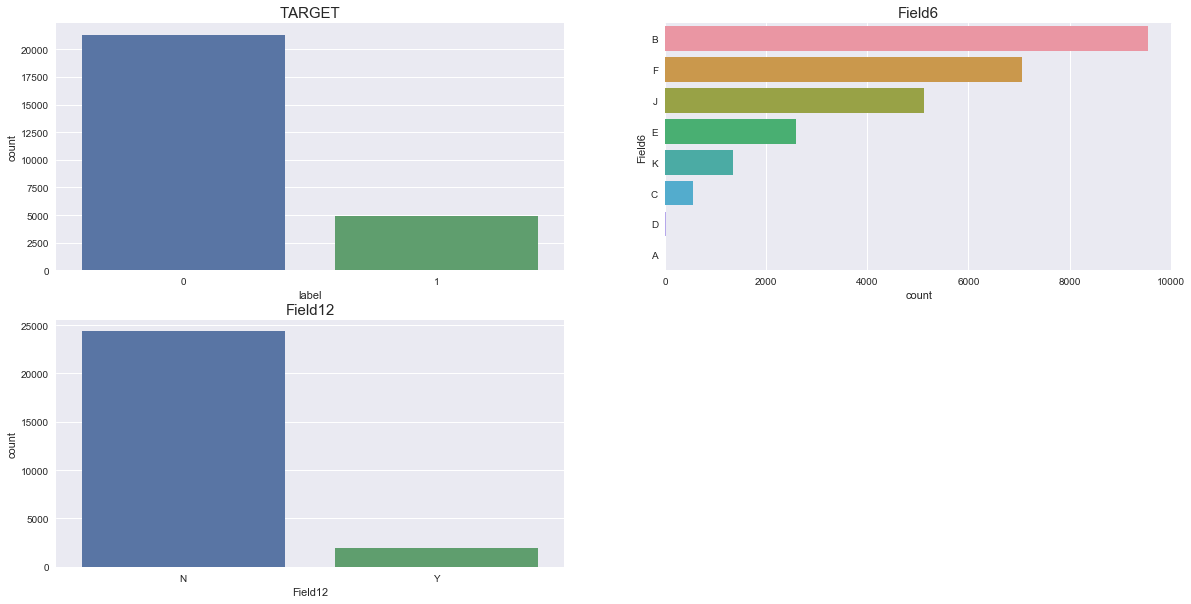

In [132]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='label', data=df_pd, order=df_pd['label'].value_counts().index)
plt.title('TARGET', fontsize=15)
plt.subplot(222)
sns.countplot(y='Field6', data=df_pd, order=df_pd['Field6'].value_counts().index)
plt.title('Field6', fontsize=15)
plt.subplot(223)
sns.countplot(x='Field12', data=df_pd, order=df_pd['Field12'].value_counts().index)
plt.title('Field12', fontsize=15)
plt.show()

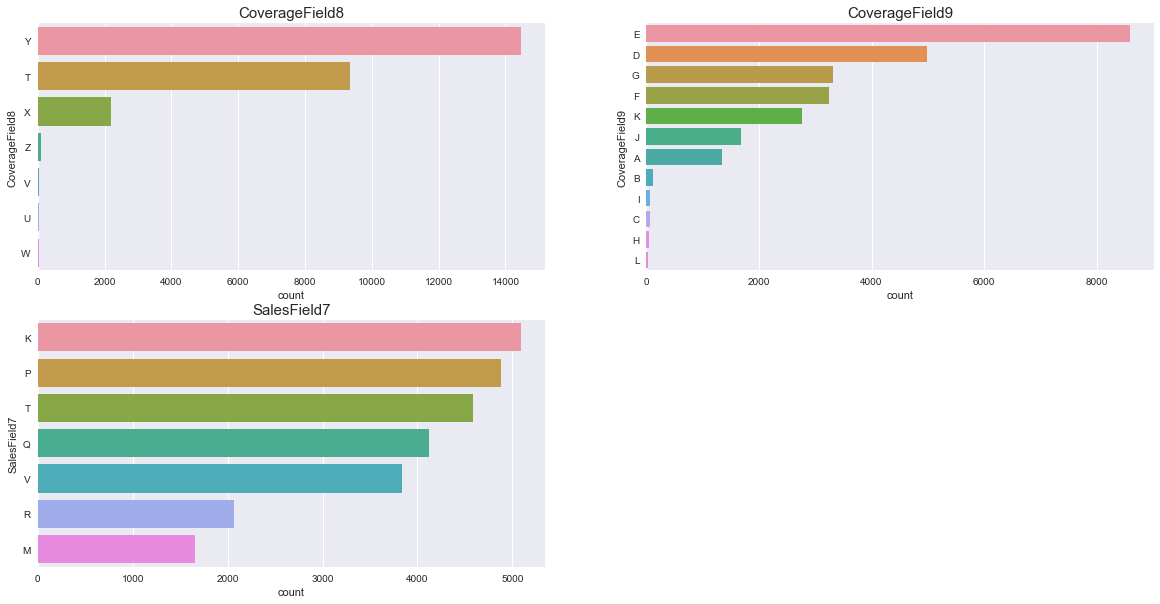

In [134]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(y='CoverageField8', data=df_pd, order=df_pd['CoverageField8'].value_counts().index)
plt.title('CoverageField8', fontsize=15)
plt.subplot(222)
sns.countplot(y='CoverageField9', data=df_pd, order=df_pd['CoverageField9'].value_counts().index)
plt.title('CoverageField9', fontsize=15)
plt.subplot(223)
sns.countplot(y='SalesField7', data=df_pd, order=df_pd['SalesField7'].value_counts().index)
plt.title('SalesField7', fontsize=15)
plt.show()

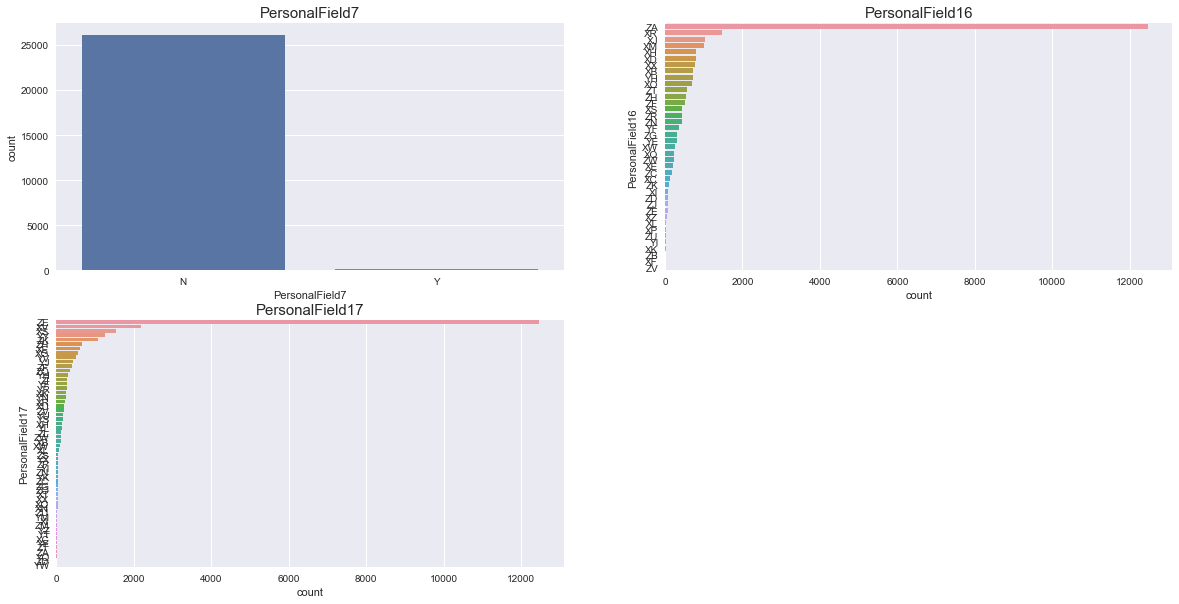

In [136]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(x='PersonalField7', data=df_pd, order=df_pd['PersonalField7'].value_counts().index)
plt.title('PersonalField7', fontsize=15)
plt.subplot(222)
sns.countplot(y='PersonalField16', data=df_pd, order=df_pd['PersonalField16'].value_counts().index)
plt.title('PersonalField16', fontsize=15)
plt.subplot(223)
sns.countplot(y='PersonalField17', data=df_pd, order=df_pd['PersonalField17'].value_counts().index)
plt.title('PersonalField17', fontsize=15)
plt.show()

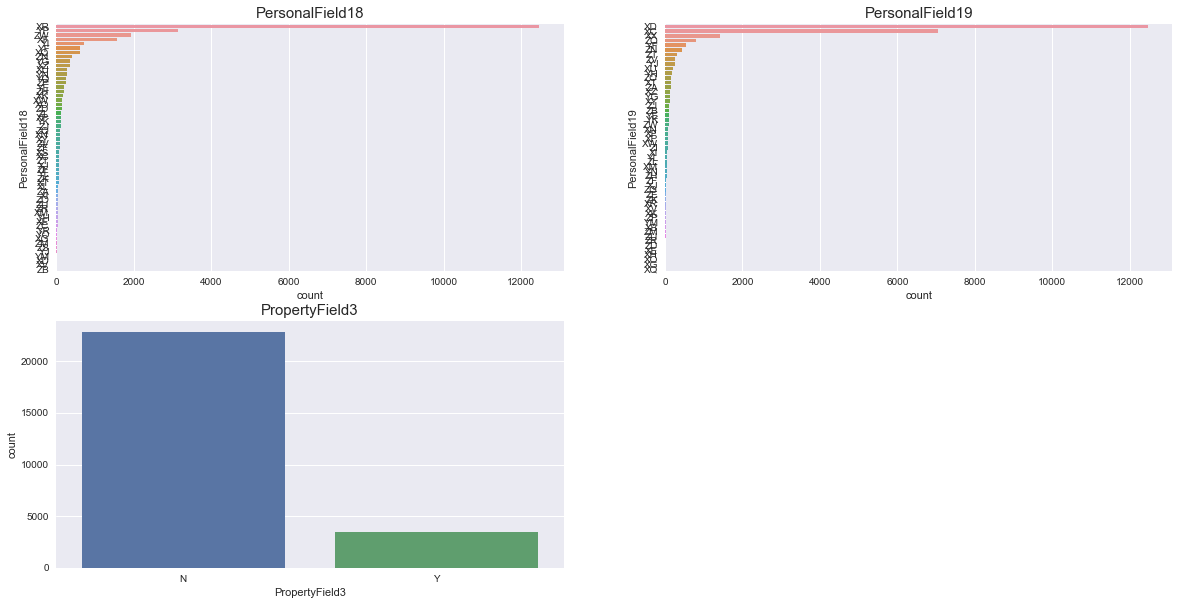

In [139]:
#Barchart for categorical variable
plt.figure(figsize=(20,10))
plt.subplot(221)
sns.countplot(y='PersonalField18', data=df_pd, order=df_pd['PersonalField18'].value_counts().index)
plt.title('PersonalField18', fontsize=15)
plt.subplot(222)
sns.countplot(y='PersonalField19', data=df_pd, order=df_pd['PersonalField19'].value_counts().index)
plt.title('PersonalField19', fontsize=15)
plt.subplot(223)
sns.countplot(x='PropertyField3', data=df_pd, order=df_pd['PropertyField3'].value_counts().index)
plt.title('PropertyField3', fontsize=15)
plt.show()

#### Categorical vs Target visualization

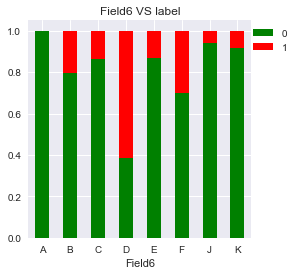

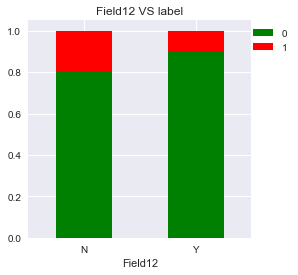

In [140]:

pd.crosstab(df_pd['Field6'], df_pd['label'], normalize='index').plot.bar(rot=0, stacked=True,
            color=['green', 'red'], figsize=(4,4), title="Field6 VS label")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))


pd.crosstab(df_pd['Field12'], df_pd['label'], normalize='index').plot.bar(rot=0, stacked=True,                            
            color=['green', 'red'], figsize=(4,4), title="Field12 VS label")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

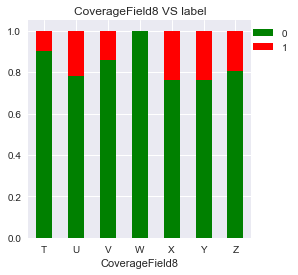

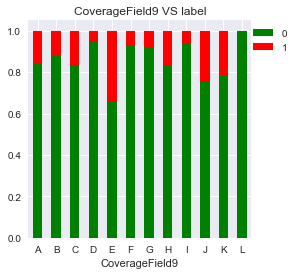

In [141]:

pd.crosstab(df_pd['CoverageField8'], df_pd['label'], normalize='index').plot.bar(rot=0, stacked=True,
            color=['green', 'red'], figsize=(4,4), title="CoverageField8 VS label")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))


pd.crosstab(df_pd['CoverageField9'], df_pd['label'], normalize='index').plot.bar(rot=0, stacked=True,                            
            color=['green', 'red'], figsize=(4,4), title="CoverageField9 VS label")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

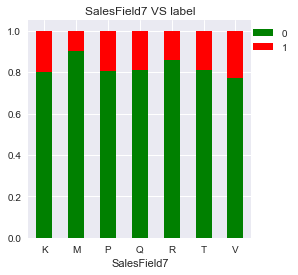

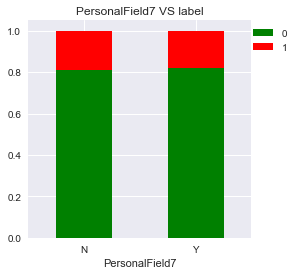

In [142]:

pd.crosstab(df_pd['SalesField7'], df_pd['label'], normalize='index').plot.bar(rot=0, stacked=True,
            color=['green', 'red'], figsize=(4,4), title="SalesField7 VS label")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))


pd.crosstab(df_pd['PersonalField7'], df_pd['label'], normalize='index').plot.bar(rot=0, stacked=True,                            
            color=['green', 'red'], figsize=(4,4), title="PersonalField7 VS label")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

###### Insignificant Categories in Data train

From visualization above we can see, there are much categories with minimal number let's say under 0.7 per cent from total observations 260753. Those minimal numbers of categories called insignificant categories and will replace with the largest numbers of catories in each categorical columns.


In [44]:
threshold=98
threshold2=0.7

In [45]:
def replace_cat2(f,cols):
    """input are dataframe and categorical variables, replace insignificant categories (percentage <=0.7) with largest number
    of catgories and output is new dataframe """
    df_percent=f.groupBy(cols).count().sort(col("count").desc())\
                .withColumn('total',sum(col('count')).over(window))\
                .withColumn('Percent',col('count')*100/col('total')) #calculate the percentage-save in Percent columns from each categories
    dominant_cat=df_percent.select(df_percent['Percent']).collect()[0][0] #calculate the highest percentage of category
    count_dist=f.select([cols]).distinct().count() #calculate distinct values in that columns
    if count_dist > 2 and dominant_cat <= threshold :
        print('column:', cols)
        cols_names.append(cols)  #combine with previous list
        replacement=f.groupBy(cols).count().sort(col("count").desc()).collect()[0][0] #define dominant category 
        print("replacement:",replacement)
        replacing.append(replacement) #combine with previous list
        insign_cat=df_percent.filter(df_percent['Percent']< threshold2).select(df_percent[cols]).collect() #calculate insignificant categories
        insign_cat=[r[cols] for r in insign_cat] #just take the values
        category.append(insign_cat) #combine with previous list
        print("insign_cat:",insign_cat)
        f=f.replace(insign_cat,replacement, cols) #replace insignificant categories with dominant categories
    return f

In [198]:
df_percent=df_final.groupBy('Field6').count().sort(col("count").desc())\
                    .withColumn('total',sum(col('count')).over(window))\
                    .withColumn('Percent',col('count')*100/col('total')) #calculate the percentage-save in Percent columns from each categories
df_percent.show()
#dominant_cat=df_percent.select(df_percent['Percent']).collect()[0][0]
#dominant_cat

+------+-----+------+--------------------+
|Field6|count| total|             Percent|
+------+-----+------+--------------------+
|     B|94694|260753|  36.315593684444664|
|     F|69053|260753|  26.482149773923982|
|     J|51782|260753|   19.85864016904887|
|     E|26063|260753|   9.995282892239015|
|     K|13226|260753|   5.072233109494426|
|     C| 5660|260753|   2.170636579444915|
|     D|  240|260753| 0.09204112704360065|
|     A|   35|260753|0.013422664360525095|
+------+-----+------+--------------------+



In [46]:
#call function replacing insignificant categories 
replacing=[]
cols_names=[]
category=[]
for cols in cat_cols:
    df_final=replace_cat2(df_final,cols)

column: Field6
replacement: B
insign_cat: ['D', 'A']
column: CoverageField8
replacement: Y
insign_cat: ['Z', 'U', 'V', 'W']
column: CoverageField9
replacement: E
insign_cat: ['B', 'I', 'H', 'C', 'L']
column: SalesField7
replacement: K
insign_cat: []
column: PersonalField16
replacement: ZA
insign_cat: ['XC', 'ZK', 'XI', 'ZD', 'ZE', 'XZ', 'ZJ', 'XL', 'XP', 'ZU', 'YI', 'XK', 'XF', 'ZB', 'XN', 'XT', 'ZI', 'XU', 'XY', 'ZO', 'ZQ', 'ZV', 'XV', 'ZL', 'ZS', 'ZP']
column: PersonalField17
replacement: ZE
insign_cat: ['YU', 'YS', 'YL', 'XH', 'ZL', 'ZW', 'XB', 'XW', 'XL', 'ZS', 'YK', 'YX', 'ZN', 'ZO', 'ZG', 'ZC', 'ZP', 'YI', 'XT', 'XN', 'ZU', 'XC', 'YM', 'XI', 'XQ', 'XX', 'YT', 'ZM', 'YE', 'ZT', 'YZ', 'ZA', 'YQ', 'ZD', 'YW', 'YG', 'XD', 'ZR', 'YP', 'XM', 'XP', 'XY', 'XJ', 'ZB', 'XO']
column: PersonalField18
replacement: XR
insign_cat: ['XK', 'XW', 'ZD', 'XO', 'ZL', 'XP', 'ZJ', 'ZF', 'YK', 'XN', 'ZV', 'ZQ', 'ZT', 'XY', 'XJ', 'XS', 'YL', 'XC', 'ZK', 'ZE', 'ZA', 'XT', 'ZU', 'ZR', 'XL', 'XI', 'ZO', 'XM

In [200]:
df_percent=df_final.groupBy('PersonalField17').count().sort(col("count").desc())\
                    .withColumn('total',sum(col('count')).over(window))\
                    .withColumn('Percent',col('count')*100/col('total')) #calculate the percentage-save in Percent columns from each categories
df_percent.show()

+---------------+------+------+------------------+
|PersonalField17| count| total|           Percent|
+---------------+------+------+------------------+
|             ZE|143089|260753| 54.87530344809072|
|             XV| 20857|260753|7.9987574447849115|
|             XS| 15733|260753| 6.033679382404038|
|             YY| 12619|260753| 4.839445759013319|
|             ZK| 10780|260753| 4.134180623041729|
|             ZH|  6925|260753|2.6557700199038936|
|             XE|  5978|260753|2.2925910727776864|
|             XG|  5667|260753|  2.17332111231702|
|             YV|  4937|260753|1.8933626842260682|
|             ZF|  4180|260753|1.6030496293427112|
|             YJ|  3946|260753|1.5133095304752007|
|             ZQ|  3695|260753| 1.417049851775435|
|             YH|  3045|260753|1.1677717993656833|
|             ZI|  2923|260753|1.1209842264518528|
|             YF|  2729|260753|1.0465843154249423|
|             YR|  2547|260753|0.9767864607502119|
|             YN|  2495|260753|

In [75]:
type(df_final)

pyspark.sql.dataframe.DataFrame

In [47]:
#check length in list cols_names, category and replacing
len(cols_names), len(category), len(replacing)

(15, 15, 15)

From **replace_cat2** function above we got 3 list,  are:
1. list of columns, actually this list same with list categorical columns --> cols_names
2. list of replaced categories --> category
3. list of replacing categories --> replacing

Those three list will be created into dataframe called **g**.

In [48]:
#Create dataframe of replaced categories
g=spark.createDataFrame(list(zip(cols_names, replacing, category)),['cols_names', 'replacing', 'category'])
g.show(9)

+---------------+---------+--------------------+
|     cols_names|replacing|            category|
+---------------+---------+--------------------+
|         Field6|        B|              [D, A]|
| CoverageField8|        Y|        [Z, U, V, W]|
| CoverageField9|        E|     [B, I, H, C, L]|
|    SalesField7|        K|                  []|
|PersonalField16|       ZA|[XC, ZK, XI, ZD, ...|
|PersonalField17|       ZE|[YU, YS, YL, XH, ...|
|PersonalField18|       XR|[XK, XW, ZD, XO, ...|
|PersonalField19|       XD|[ZO, XT, ZA, YG, ...|
| PropertyField7|        O|[K, H, E, L, F, G...|
+---------------+---------+--------------------+
only showing top 9 rows



In [205]:
g.dtypes

[('cols_names', 'string'),
 ('replacing', 'string'),
 ('category', 'array<string>')]

In [206]:
g.printSchema()

root
 |-- cols_names: string (nullable = true)
 |-- replacing: string (nullable = true)
 |-- category: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [49]:
f_percent=df_final.groupBy('CoverageField8').count().sort(col("count").desc())\
                       .withColumn('total',sum(col('count')).over(window))\
                       .withColumn('Percent',col('count')*100/col('total'))

In [50]:
f_percent.show()

+--------------+------+------+------------------+
|CoverageField8| count| total|           Percent|
+--------------+------+------+------------------+
|             Y|145350|260753|55.742407565780645|
|             T| 93778|260753|35.964303382894926|
|             X| 21625|260753| 8.293289051324434|
+--------------+------+------+------------------+



### Replacing Insignificant Categories in data test

We already have a dataframe containing any categories that need to be replaced, we got it when the process of replacing the insignificant categories in the data train, the data frame is called **g**. 
Based on those information, insignificant categories on data test will be replaced.

In [51]:
#view g dataframe
g.show(15)

+-----------------+---------+--------------------+
|       cols_names|replacing|            category|
+-----------------+---------+--------------------+
|           Field6|        B|              [D, A]|
|   CoverageField8|        Y|        [Z, U, V, W]|
|   CoverageField9|        E|     [B, I, H, C, L]|
|      SalesField7|        K|                  []|
|  PersonalField16|       ZA|[XC, ZK, XI, ZD, ...|
|  PersonalField17|       ZE|[YU, YS, YL, XH, ...|
|  PersonalField18|       XR|[XK, XW, ZD, XO, ...|
|  PersonalField19|       XD|[ZO, XT, ZA, YG, ...|
|   PropertyField7|        O|[K, H, E, L, F, G...|
|  PropertyField14|        C|                 [D]|
|  PropertyField28|        B|                 [C]|
|  PropertyField31|        O|                  []|
|  PropertyField33|        H|                  []|
|GeographicField63|        N|                 [ ]|
|GeographicField64|       CA|                  []|
+-----------------+---------+--------------------+



In [52]:
cols_names_list=g.select('cols_names').collect() #select just cols_names from dataframe g
cols_names_list=[r['cols_names'] for r in cols_names_list] #take just the values

#function to replace insignificant categories in data test
for z in cols_names_list:
    print('cols_names:',z)
    replacement_cat=g.filter(g['cols_names']== z).select(g['replacing']).collect()[0][0] #select values of replacing columns accoring to z in cols_names 
    print('replacement_cat:', replacement_cat)
    insignificant_cat=g.filter(g['cols_names']== z).select(g['category']).collect()[0][0] #select values of category columns accoring to z in cols_names
    print('insignificant_cat:',insignificant_cat)
    test_data=test_data.replace(insignificant_cat,replacement_cat, z) #replace insignificant cat with replacement value

cols_names: Field6
replacement_cat: B
insignificant_cat: ['D', 'A']
cols_names: CoverageField8
replacement_cat: Y
insignificant_cat: ['Z', 'U', 'V', 'W']
cols_names: CoverageField9
replacement_cat: E
insignificant_cat: ['B', 'I', 'H', 'C', 'L']
cols_names: SalesField7
replacement_cat: K
insignificant_cat: []
cols_names: PersonalField16
replacement_cat: ZA
insignificant_cat: ['XC', 'ZK', 'XI', 'ZD', 'ZE', 'XZ', 'ZJ', 'XL', 'XP', 'ZU', 'YI', 'XK', 'XF', 'ZB', 'XN', 'XT', 'ZI', 'XU', 'XY', 'ZO', 'ZQ', 'ZV', 'XV', 'ZL', 'ZS', 'ZP']
cols_names: PersonalField17
replacement_cat: ZE
insignificant_cat: ['YU', 'YS', 'YL', 'XH', 'ZL', 'ZW', 'XB', 'XW', 'XL', 'ZS', 'YK', 'YX', 'ZN', 'ZO', 'ZG', 'ZC', 'ZP', 'YI', 'XT', 'XN', 'ZU', 'XC', 'YM', 'XI', 'XQ', 'XX', 'YT', 'ZM', 'YE', 'ZT', 'YZ', 'ZA', 'YQ', 'ZD', 'YW', 'YG', 'XD', 'ZR', 'YP', 'XM', 'XP', 'XY', 'XJ', 'ZB', 'XO']
cols_names: PersonalField18
replacement_cat: XR
insignificant_cat: ['XK', 'XW', 'ZD', 'XO', 'ZL', 'XP', 'ZJ', 'ZF', 'YK', 'XN', 

In [211]:
percent=df_final.groupBy('GeographicField63').count().sort(col("count").desc())\
                       .withColumn('total',sum(col('count')).over(window))\
                       .withColumn('Percent',col('count')*100/col('total'))
percent.show()

+-----------------+------+------+------------------+
|GeographicField63| count| total|           Percent|
+-----------------+------+------+------------------+
|                N|254714|260753|  97.6840151407654|
|                Y|  6039|260753|2.3159848592346015|
+-----------------+------+------+------------------+



In [212]:
f_percent=test_data.groupBy('GeographicField63').count().sort(col("count").desc())\
                       .withColumn('total',sum(col('count')).over(window))\
                       .withColumn('Percent',col('count')*100/col('total'))
f_percent.show()

+-----------------+------+------+-----------------+
|GeographicField63| count| total|          Percent|
+-----------------+------+------+-----------------+
|                N|169856|173836|97.71048574518511|
|                Y|  3980|173836|2.289514254814883|
+-----------------+------+------+-----------------+



#### Numerical Variables

We have 260 numerical variables, and we will plot just some variables.

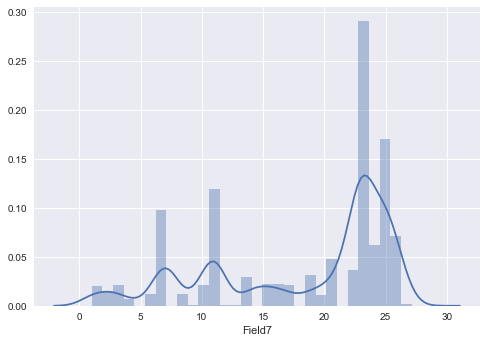

In [215]:
#density plot Field7
#plt.figure(figsize=(24,5))
sns.distplot(df_pd['Field7'])
plt.show()

#### Numerical vs Target visualization

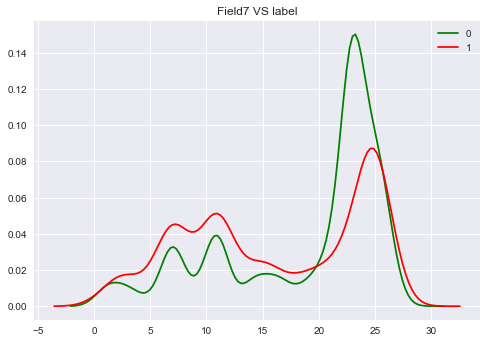

In [216]:
#show distribution 'Field7' vs 'label'
#plt.figure(figsize=(20,8))
sns.kdeplot(df_pd[df_pd["label"]==0]["Field7"], label="0", color="green")
sns.kdeplot(df_pd[df_pd["label"]==1]["Field7"], label="1", color="red")
plt.title("Field7 VS label")
plt.show()

### Check outlier

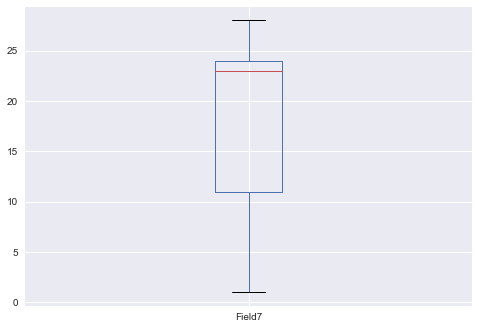

In [217]:
#Check outlier in numerical variable
df_pd[["Field7"]].boxplot(sym='g-*', grid=True)
plt.show()

### Handle of outlier
Outlier is observations that fall below lower side or above upper side.

To handle outlier we approach by replacing the value greater than upper side with upper side value and also replacing the value lower than lower side with lower side value.
So, we need calculate upper and lower side from quantile value, quantile is probability distribution of variable. In General, there are three quantile:
1. Q1 = the value that cut off 25% of the first data when it is sorted in ascending order. 
2. Q2 = cut off data, or median, it's 50 % of the data 
3. Q3 = the value that cut off 75% of the first data when it is sorted in ascending order.

IQR or interquartile range is range between Q1 and Q3. IQR = Q3 - Q1.

Upper side = Q3 + 1.5 * IQR

Lower side = Q1 - 1.5 * IQR

To calculate upper and lower side we use pandas dataframe and pyspark dataframe. Both ways have same result.
Then, we will use result from pyspark to handle outlier

### Handle of outlier in data train

#### Calculate Upper&Lower side in pandas dataframe

In [218]:
df_describe=df_pd.describe()
df_describe

,QuoteNumber,label,Field7,Field8,Field9,Field10,Field11,CoverageField1A,CoverageField1B,CoverageField2A,...,GeographicField58A,GeographicField58B,GeographicField59A,GeographicField59B,GeographicField60A,GeographicField60B,GeographicField61A,GeographicField61B,GeographicField62A,GeographicField62B
count,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,...,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000,26239.000000
mean,216470.226952,0.188460,18.284767,0.938466,0.001465,950.580700,1.162168,9.011471,13.010671,9.055795,...,11.507794,12.900720,11.690728,13.036129,-0.361866,12.934068,-0.358893,12.986242,-0.344030,14.094897
std,125864.692290,0.391086,7.375948,0.037184,0.001493,290.298805,0.116729,5.568995,7.204728,5.552631,...,5.455040,7.236423,5.640301,7.237964,4.023045,7.232334,4.032168,7.142827,4.077445,5.816711
min,13.000000,0.000000,1.000000,0.874600,0.000400,548.000000,1.000000,-1.000000,-1.000000,1.000000,...,-1.000000,-1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,107131.000000,0.000000,11.000000,0.915300,0.000600,564.000000,1.020000,5.000000,7.000000,5.000000,...,8.000000,7.000000,7.000000,7.000000,-1.000000,7.000000,-1.000000,7.000000,-1.000000,8.000000
50%,216172.000000,0.000000,23.000000,0.940300,0.000600,965.000000,1.188600,8.000000,13.000000,8.000000,...,11.000000,13.000000,11.000000,13.000000,-1.000000,13.000000,-1.000000,13.000000,-1.000000,13.000000
75%,325870.500000,0.000000,24.000000,0.968500,0.003800,1113.000000,1.266500,12.000000,19.000000,12.000000,...,15.000000,19.000000,15.000000,19.000000,-1.000000,19.000000,-1.000000,19.000000,-1.000000,19.000000
max,434588.000000,1.000000,28.000000,1.010100,0.004000,1487.000000,1.304500,25.000000,25.000000,25.000000,...,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000


In [55]:
#create quantile dataframe
def quantile(e):
    """Input is dataframe and return new dataframe with value of quantile from numerical columns"""
    percentiles = [0.25, 0.5, 0.75]
    quant=spark.createDataFrame(zip(percentiles, *e.approxQuantile(num_cols, percentiles, 0.0)),
                               ['percentile']+num_cols) #calculate quantile from pyspark dataframe, 0.0 is relativeError,
                                                        #The relative target precision to achieve (>= 0). If set to zero, 
                                                        #the exact quantiles are computed, which could be very expensive
                                                        #and aggregate the result with percentiles variable, 
                                                        #then create pyspark dataframe
    return quant

In [56]:
#call function quantile and apply to data train sample(df_sample)
%time quantile=quantile(df_sample)

Wall time: 52.1 s


In [57]:
#function to calculate uppler side
def upper_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun upper value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1  #calculate the value of IQR
    upper= q3 + (IQR*1.5)   #calculate the value of upper side
    return upper

In [222]:
help(upper_value)

Help on function upper_value in module __main__:

upper_value(b, c)
    Input is quantile dataframe and name of numerical column and Retrun upper value from the column



In [58]:
#function to calculate lower side
def lower_value(b,c):
    """Input is quantile dataframe and name of numerical column and Retrun lower value from the column"""
    q1 = b.select(c).collect()[0][0] #select value of q1 from the column
    q2 = b.select(c).collect()[1][0] #select value of q2 from the column
    q3 = b.select(c).collect()[2][0] #select value of q3 from the column
    IQR=q3-q1                   #calculate the value of IQR
    lower= q1 - (IQR*1.5)       #calculate the value of lower side
    return lower

#### Replacing the outlier

In [59]:
#function for replacing outlier by upper side
def replce_outlier_up2(d,col, value):
    """Input is name of numerical column and it's upper side value"""
    d=d.withColumn(col, F.when(d[col] > value , value).otherwise(d[col]))
    return d

In [60]:
#function for replacing outlier by lower side
def replce_outlier_low2(d,col, value):
    """Input is name of numerical column and it's lower side value"""
    d=d.withColumn(col, F.when(d[col] < value , value).otherwise(d[col]))
    return d

In [226]:
%time lower_Field7=lower_value(quantile,'Field7')

Wall time: 18.6 s


In [62]:
%time lower_Field7

Wall time: 0 ns


-8.5

In [227]:
%time df_final=replce_outlier_low2(df_final, 'Field7', lower_Field7)

Wall time: 206 ms


In [228]:
%time upper_Field7=upper_value(quantile,'Field7')

Wall time: 16.8 s


In [229]:
%time df_final=replce_outlier_up2(df_final, 'Field7', upper_Field7)

Wall time: 104 ms


In [61]:
#call function to calculate lower side and replace value under lower side with value lower side at all numerical variables
for i in num_cols:
    lower=lower_value(quantile,i)
    df_final=replce_outlier_low2(df_final, i, lower)

In [62]:
#call function to calculate upper side and replace value above upper side with value upper side at all numerical variables
for x in num_cols:
    upper=upper_value(quantile,x)
    df_final=replce_outlier_up2(df_final, x, upper)

In [68]:
type(df_final)

pyspark.sql.dataframe.DataFrame

In [69]:
df_final.select('QuoteNumber').show(5)

+-----------+
|QuoteNumber|
+-----------+
|          1|
|          2|
|          4|
|          6|
|          8|
+-----------+
only showing top 5 rows



### Handle of outlier in data test

In [109]:
pd_9=test_data.toPandas()

In [110]:
pd_9.describe()

,Id,MSSubClass,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.645648,9819.161069,1971.357779,1983.662783,100.712132,439.203564,52.619602,554.294722,...,472.769020,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,20.561791,4955.517327,30.390071,21.130467,176.709827,455.111888,176.693301,437.110508,...,216.974165,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,60.000000,7391.000000,1953.000000,1963.000000,0.000000,0.000000,0.000000,219.500000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,69.000000,9399.000000,1973.000000,1992.000000,0.000000,351.000000,0.000000,460.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,78.000000,11517.500000,2001.000000,2004.000000,162.000000,752.000000,0.000000,797.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,2010.000000,2010.000000,1290.000000,4010.000000,1526.000000,2140.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [63]:
#create quantile dataframe
def quantile(e):
    """Input is dataframe and return new dataframe with value of quantile from numerical columns"""
    percentiles = [0.25, 0.5, 0.75]
    quant=spark.createDataFrame(zip(percentiles, *e.approxQuantile(num_cols_test, percentiles, 0.0)),
                               ['percentile']+num_cols_test) #calculate quantile from pyspark dataframe, 0.0 is relativeError,
                                                        #The relative target precision to achieve (>= 0). If set to zero, 
                                                        #the exact quantiles are computed, which could be very expensive
                                                        #and aggregate the result with percentiles variable, 
                                                        #then create pyspark dataframe
    return quant

In [64]:
#call funtion quantile
quantile=quantile(test_sample)

In [65]:
#call function to calculate lower side and replace value under lower side with value lower side at all numerical variables
for i in num_cols_test:
    lower=lower_value(quantile,i)
    test_data=replce_outlier_low2(test_data, i, lower)

In [71]:
#call function to calculate upper side and replace value above upper side with value upper side at all numerical variables
for x in num_cols_test:
    upper=upper_value(quantile,x)
    test_data=replce_outlier_up2(test_data, x, upper)

### Feature Engineering
Before splitting the data train, all categorical variables must be made numerical. There are several approaches to categorical variables in SparkML, including:
1. StringIndexer, which is to encode the string label into the index label by sequencing the string frequency descending and giving the smallest index (0)
at most string frequency.
2. One-hot Encoding, which is mapping the label column (string label) on the binary column.
3. Vector assembler, which is mapping all columns in vector.

In [42]:
def check_distinct(a1,a2):
    """input are two dataframe that you want to compare categorical variables and the output is 
    total distinct categories in both dataframe"""
    total1=0
    total2=0
    for y in cat_cols:
        distinct1=a1.select([y]).distinct().count() #count distinct column in dataframe1
        distinct2=a2.select([y]).distinct().count() #count distinct column in dataframe2
        var1=a1.select([y]).distinct().collect() #define distinct category in column in dataframe1
        var1=[r[y] for r in var1]
        var2=a2.select([y]).distinct().collect()
        var2=[r[y] for r in var2]
        total1=total1+distinct1
        total2=total2+distinct2   
    return total1, total2    

In [48]:
#function to execute feature engineering
def feature_engineering(a1):    
    """Function for feature engineering (StringIndexer and OneHotEncoder process)"""
    cat_columns_string_vec = []
    for c in cat_cols:
        cat_columns_string= c+"_vec"
        cat_columns_string_vec.append(cat_columns_string)
    stringIndexer = [StringIndexer(inputCol=x, outputCol=x+"_Index")
                  for x in cat_cols]
    #use oneHotEncoder to convert categorical variable to binary
    encoder = [OneHotEncoder(inputCol=x+"_Index", outputCol=y)
           for x,y in zip(cat_cols, cat_columns_string_vec)]
    #create list of stringIndexer and encoder with 2 dimension
    tmp = [[i,j] for i,j in zip(stringIndexer, encoder)]
    tmp = [i for sublist in tmp for i in sublist]
    cols_assember=num_id + num_cols + cat_columns_string_vec
    assembler=VectorAssembler(inputCols=cols_assember, outputCol='features')
    tmp += [assembler]
    pipeline=Pipeline(stages=tmp)
    df_final_feat=pipeline.fit(a1).transform(a1)
    return df_final_feat

In [49]:
#fucntion to call fucntion feature_engineering and check_distinct
def Main_feature_engineering(df,df2): 
    """Function for calling check_distinct and feature_engineering. Then Join data train and data test if distinct categories 
    between data train and data test not same then do feature engineering, If distinct same will do feature engineering data train
    and data test separately"""
    dist_total1, dist_total2=check_distinct(df,df2)   
    if dist_total1!=dist_total2:
        Label_df=df.select('Id', 'label')
        df_final2=df.drop('label')
        all_df =df_final2.union(df2)
        all_df_feat=feature_engineering(all_df)
        id_train=df.select('Id').collect()
        id_train=[r['Id'] for r in id_train]
        id_test=df2.select('Id').collect()
        id_test=[r['Id'] for r in id_test]
        a=all_df_feat.filter(all_df['Id'].isin(id_train))
        b=all_df_feat.filter(all_df['Id'].isin(id_test))
        a=a.join(Label_df, 'Id')
    else:
        a=feature_engineering(df)
        b=feature_engineering(df2)        
    return a,b

### Call function feature engineering

In [66]:
#call function feature engineering
%time data2, test2=Main_feature_engineering(df_final, test_data)

Wall time: 8min 43s


In [67]:
#view result of feature engineering in data train
data2.select('Id', 'features').show(5)

+---+--------------------+
| Id|            features|
+---+--------------------+
|  1|(391,[0,1,2,3,4,5...|
|  2|(391,[0,1,2,3,4,5...|
|  4|(391,[0,1,2,3,4,5...|
|  6|(391,[0,1,2,3,4,5...|
|  8|(391,[0,1,2,3,4,5...|
+---+--------------------+
only showing top 5 rows



In [68]:
#view result of feature engineering in data test
test2.select('Id', 'features').show(5)

+---+--------------------+
| Id|            features|
+---+--------------------+
|  3|(391,[0,1,2,3,4,5...|
|  5|(391,[0,1,2,3,4,5...|
|  7|(391,[0,1,2,3,4,5...|
|  9|(391,[0,1,2,3,4,5...|
| 10|(391,[0,1,2,3,4,5...|
+---+--------------------+
only showing top 5 rows



### Split Data train to train and test

In [ ]:
#Split df_final to train and test, train 70% and test 30%. Define seed 24 so the random data that we split will not change.
#we can define seed with any value
data_train, data_test=data2.randomSplit([0.7,0.3], 24)

### Modelling 
We will use four algorithm to make a model and prediction, they are:

1. Logistic Regression
Logistic regression used logit function in prediction the probability. 
2. Decision Tree
This algorithm will find the most significant independent variable to  create a group. 
3. Random Forest
This algorithm build multiple decision trees and merges them together and use bagging method.
4. Gradient Boosting 
This algorithm use boosting ensemble technic. This technique employs the logic in which the subsequent predictors learn from the mistakes of the previous predictors.

### Evaluation
To evaluate model we use four metrics, they are:

1. ##### ROC
ROC (Receiver Operating Characteristic)
The graph shows the true positive rate versus the false positive rate.
This metric is between 0 and 1 with a better model scoring higher.
An area of 1 represents a perfect test; an area of .5 represents a worthless test. So, The model is said to be good enaught if the value of the area under the curve is above 0.5

2. ##### Gini Coefficient
Gini is ratio between the ROC curve and the diagnol line & the area of the above triangle. So, we can calculate Gini by this formula:
Gini = 2*AUC - 1
Such as AUC ROC, Gini above 50% or 60% is good model.

3. ##### Confusion Matrix
Confusion Matrix is a table is used to describe performance of a classification model. Some definition are:
  a. Accuracy = Proportion of total number of predictions that were correct
  b. Precision (Positive Predictive Value) : Proportion of positive cases that were correctly identified.
  c. Negative Predictive Value : Proportion of negative cases that were correctly identified.
  d. Sensitivity (Recall) : Proportion of actual positive cases which are correctly identified.
  e. Specificity : Proportion of actual negative cases which are correctly identified.
  
4. ##### Log Loss
Log Loss is one of model performance evaluation in classification model. The purpose of model is to minimize log loss value. A perfect model would have of log loss of 0.
Log Loss increase when predicted probability diverges from actual label.

### Modelling & Evaluation

#### Logistic Regression 

In [81]:
#Create logistic regression model to data train
lr=LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(data_train)

#Transform model to data test
lr_result = lr_model.transform(data_test)

In [82]:
#view id, label, prediction and probability from result of modelling
lr_result.select('Id', 'label', 'prediction', 'probability').show(5)

+-----------+-----+----------+--------------------+
|QuoteNumber|label|prediction|         probability|
+-----------+-----+----------+--------------------+
|          1|    0|       0.0|[0.98970992249340...|
|          2|    0|       0.0|[0.94277193429369...|
|          6|    0|       0.0|[0.96793973374689...|
|         12|    0|       0.0|[0.95114651013774...|
|         13|    0|       0.0|[0.99965320682235...|
+-----------+-----+----------+--------------------+
only showing top 5 rows



#### Logistic Regression Evaluation

In [79]:
#Evaluate model by checking accuracy and AUC value
lr_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
lr_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
lr_AUC  = lr_eval.evaluate(lr_result)
lr_ACC  = lr_eval2.evaluate(lr_result, {lr_eval2.metricName:"accuracy"})

print("Logistic Regression Performance Measure")
print("Accuracy = %0.2f" % lr_ACC)
print("AUC = %.2f" % lr_AUC)

Logistic Regression Performance Measure
Accuracy = 0.89
AUC = 0.89


##### ROC Grafik

Logistic Regression Area Under ROC
Area under ROC = 0.89


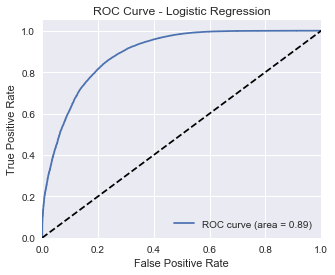

In [83]:
#Create ROC grafik from lr_result
PredAndLabels           = lr_result.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Logistic Regression Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

In [95]:
cm_lr_result = lr_result.crosstab("prediction", "label")
cm_lr_result = cm_lr_result.toPandas()
cm_lr_result

,prediction_label,0,1
0,1.0,1918,8294
1,0.0,61886,6451


In [96]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cm_lr_result["1"][0]
FP = cm_lr_result["0"][0]
TN = cm_lr_result["0"][1]
FN = cm_lr_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.89
Sensitivity = 0.56
Specificity = 0.97
Precision = 0.81


##### Calculate Gini  Coefficient from AUC

In [86]:
AUC = lr_AUC
Gini = (2 * AUC - 1)
print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini)

AUC=0.89
GINI ~=0.78


##### Calculate Log Loss in pandas dataframe

In [87]:
#Create Dataframe to Calculate Log Loss
y_test= data_test.select('label')
lr_proba=lr_result.select('probability')

In [88]:
#Convert lr_probaspark dataframe to numpy array
lr_proba= np.array(lr_result.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
lr_proba=lr_proba.reshape(-1, lr_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)

In [89]:
#Calculate log loss from logistic regression
LogLoss = log_loss(y_test, lr_proba) 

print("Log Loss Linear Regression:%.4f" % LogLoss)

Log Loss Linear Regression:0.2821


#### Logistic Regression With Hyper-Parameter Tuning

In [ ]:
#define logistic regression model
lr_hyper=LogisticRegression(featuresCol='features', labelCol='label')


#Hyper-Parameter Tuning
paramGrid_lr = ParamGridBuilder() \
    .addGrid(lr_hyper.regParam, [0.1, 0.01]) \
    .addGrid(lr_hyper.elasticNetParam, [0.8, 0.7]) \
    .build()
crossval_lr = CrossValidator(estimator=lr_hyper,
                             estimatorParamMaps=paramGrid_lr,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3)
#fit model to data train
lr_model_hyper = crossval_lr.fit(data_train)


In [ ]:
#Transform model to data test
lr_result_hyper = lr_model_hyper.transform(data_test)

In [ ]:
#view id, label, prediction and probability from result of modelling
lr_result_hyper.select('Id', 'label', 'prediction', 'probability').show(5)

#### Logistic Regression With Hyper-Parameter Tuning Evaluation

In [ ]:
#Evaluate model by checking accuracy and AUC value
lr_hyper_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
lr_hyper_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
lr_hyper_AUC  = lr_hyper_eval.evaluate(lr_result_hyper)
lr_hyper_ACC  = lr_hyper_eval2.evaluate(lr_result_hyper, {lr_hyper_eval2.metricName:"accuracy"})

print("Logistic Regression Performance Measure")
print("Accuracy = %0.2f" % lr_hyper_ACC)
print("AUC = %.2f" % lr_hyper_AUC)

##### ROC Grafik

In [ ]:
PredAndLabels           = lr_result_hyper.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Logistic Regression Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

##### Confution Matrix

In [ ]:
cm_lr_result_hyper = lr_result_hyper.crosstab("prediction", "label")
cm_lr_result_hyper = cm_lr_result_hyper.toPandas()
cm_lr_result_hyper

In [ ]:
#calculate Accuracy, Sensitivity, Specificity, Precision
TP = cm_lr_result_hyper["1"][0]
FP = cm_lr_result_hyper["0"][0]
TN = cm_lr_result_hyper["0"][1]
FN = cm_lr_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

##### Calculate Gini Coefisient from AUC

In [ ]:
AUC = lr_hyper_AUC
Gini_lr_hyper = (2 * AUC - 1)
print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_lr_hyper)

##### Calculate Log Loss in pandas dataframe

In [ ]:
#Create Dataframe to Calculate Log Loss
y_test= titanic_test.select('label')
lr_hyper_proba=lr_result_hyper.select('probability')

In [ ]:
#Convert lr_probaspark dataframe to numpy array
lr_hyper_proba= np.array(lr_hyper_proba.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
lr_hyper_proba=lr_hyper_proba.reshape(-1, lr_hyper_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)

In [ ]:
#Calculate log loss from logistic regression hyper parameter
LogLoss = log_loss(y_test, lr_hyper_proba) 

print("Log Loss Linear Regression:%.4f" % LogLoss)

#### Decision Tree

In [90]:
#Create decision tree model to data train
dt=DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dt_model = dt.fit(data_train)

##Transform model to data test
dt_result = dt_model.transform(data_test)

In [91]:
#view id, label, prediction and probability from result of modelling
dt_result.select('Id', 'label', 'prediction', 'probability').show(5)

+-----------+-----+----------+--------------------+
|QuoteNumber|label|prediction|         probability|
+-----------+-----+----------+--------------------+
|          1|    0|       0.0|[0.93437569103893...|
|          2|    0|       0.0|[0.93437569103893...|
|          6|    0|       0.0|           [1.0,0.0]|
|         12|    0|       0.0|[0.69059559980964...|
|         13|    0|       0.0|[0.93437569103893...|
+-----------+-----+----------+--------------------+
only showing top 5 rows



#### Decision Tree Evaluation

In [92]:
#Evaluate model by calculating accuracy and area under curve (AUC)
dt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
dt_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
dt_AUC  = dt_eval.evaluate(dt_result)
dt_ACC  = dt_eval2.evaluate(dt_result, {dt_eval2.metricName:"accuracy"})

print("Decision Tree Performance Measure")
print("Accuracy = %0.2f" % dt_ACC)
print("AUC = %.2f" % dt_AUC)

Decision Tree Performance Measure
Accuracy = 0.88
AUC = 0.86


##### ROC Grafik

Decision Tree Area Under ROC
Area under ROC = 0.86


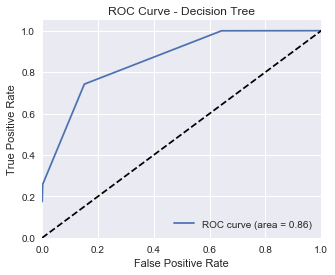

In [93]:
PredAndLabels           = dt_result.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Decision Tree Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

In [97]:
cm_dt_result = dt_result.crosstab("prediction", "label")
cm_dt_result = cm_dt_result.toPandas()
cm_dt_result

,prediction_label,0,1
0,1.0,25,5263
1,0.0,63779,9482


In [98]:
#calculate accuracy, sensitivity, specificity and precision
TP = cm_dt_result["1"][0]
FP = cm_dt_result["0"][0]
TN = cm_dt_result["0"][1]
FN = cm_dt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.88
Sensitivity = 0.36
Specificity = 1.00
Precision = 1.00


##### Calculate Gini Coeffiecient from AUC 

In [94]:
AUC = dt_AUC
Gini_dt = (2 * AUC - 1)
print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_dt)

AUC=0.86
GINI ~=0.72


##### Calculate Log Loss in pandas dataframe

In [99]:
#Create Dataframe to Calculate Log Loss
y_test= data_test.select('label')
dt_proba=dt_result.select('probability')

In [100]:
#Convert lr_probaspark dataframe to numpy array
dt_proba= np.array(dt_proba.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
dt_proba=dt_proba.reshape(-1, dt_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)

In [101]:
#Calculate log loss from Decision Tree
LogLoss = log_loss(y_test, dt_proba) 

print("Log Loss Decision Tree:%.4f" % LogLoss)

Log Loss Decision Tree:0.2929


#### Decision Tree With Hyper-Parameter Tuning

In [ ]:
#define desicion tree model
dt_hyper=DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', impurity='gini')

#Hyper-Parameter Tuning
paramGrid_dt = ParamGridBuilder() \
    .addGrid(dt_hyper.maxDepth, [5, 7]) \
    .addGrid(dt_hyper.maxBins, [10,20]) \
    .build()
crossval_dt = CrossValidator(estimator=dt_hyper,
                             estimatorParamMaps=paramGrid_dt,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=5)
#fit model to data train
dt_model_hyper = crossval_dt.fit(data_train)


In [ ]:
#transform model to data test
dt_result_hyper = dt_model_hyper.transform(data_test)

In [ ]:
#view id, label, prediction and probability from result of modelling 
dt_result_hyper.select('Id', 'label', 'prediction', 'probability').show(5)

#### Decision Tree With Hyper-Parameter Tuning Evaluation

In [ ]:
#Evaluate model by calculating accuracy and area under curve (AUC)
dt_hyper_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
dt_hyper_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
dt_hyper_AUC  = dt_hyper_eval.evaluate(dt_result_hyper)
dt_hyper_ACC  = dt_hyper_eval2.evaluate(dt_result_hyper, {dt_hyper_eval2.metricName:"accuracy"})

print("Decision Tree Performance Measure")
print("Accuracy = %0.2f" % dt_hyper_ACC)
print("AUC = %.2f" % dt_hyper_AUC)

##### ROC Grafik

In [ ]:
PredAndLabels           = dt_result_hyper.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Decision Tree Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

In [ ]:
cm_dt_result_hyper = dt_result_hyper.crosstab("prediction", "label")
cm_dt_result_hyper = cm_dt_result_hyper.toPandas()
cm_dt_result_hyper

In [ ]:
#calculate accuracy, sensitivity, specificity and precision
TP = cm_dt_result_hyper["1"][0]
FP = cm_dt_result_hyper["0"][0]
TN = cm_dt_result_hyper["0"][1]
FN = cm_dt_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

##### Calculate Gini Coefficient from AUC 

In [ ]:
AUC = dt_hyper_AUC
Gini_dt_hyper= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_dt_hyper)

##### Calculate Log Loss in pandas dataframe

In [ ]:
#Create Dataframe to Calculate Log Loss
y_test= data_test.select('label')
dt_hyper_proba=dt_result_hyper.select('probability')

In [ ]:
#Convert lr_probaspark dataframe to numpy array
dt_hyper_proba= np.array(dt_hyper_proba.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
dt_hyper_proba=dt_hyper_proba.reshape(-1, dt_hyper_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)

In [ ]:
#Calculate log loss from Decision Tree hyper parameter
LogLoss = log_loss(y_test, dt_hyper_proba) 

print("Log Loss Decision Tree:%.4f" % LogLoss)

#### Random Forest

In [102]:
#Create decision tree model to data train
rf = RandomForestClassifier(featuresCol='features', labelCol="label")
rf_model = rf.fit(data_train)

#transform model to data test
rf_result = rf_model.transform(data_test)

In [103]:
#view id, label, prediction and probability from result of modelling
rf_result.select('Id', 'label', 'prediction', 'probability').show(5)

+-----------+-----+----------+--------------------+
|QuoteNumber|label|prediction|         probability|
+-----------+-----+----------+--------------------+
|          1|    0|       0.0|[0.91517273017559...|
|          2|    0|       0.0|[0.82291268107459...|
|          6|    0|       0.0|[0.97064099517392...|
|         12|    0|       0.0|[0.84192959588552...|
|         13|    0|       0.0|[0.99085569112231...|
+-----------+-----+----------+--------------------+
only showing top 5 rows



#### Random Forest Evaluation

In [104]:
#Evaluate model by calculatin accuracy and area under curve (AUC)
rf_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
rf_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
rf_AUC  = rf_eval.evaluate(rf_result)
rf_ACC  = rf_eval2.evaluate(rf_result, {rf_eval2.metricName:"accuracy"})

print("Decision Tree Performance Measure")
print("Accuracy = %0.2f" % rf_ACC)
print("AUC = %.2f" % rf_AUC)

Decision Tree Performance Measure
Accuracy = 0.84
AUC = 0.91


##### ROC Grafik

Random Forest Area Under ROC
Area under ROC = 0.91


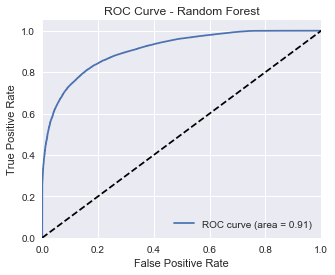

In [105]:
PredAndLabels           = rf_result.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Random Forest Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

In [106]:
cm_rf_result = rf_result.crosstab("prediction", "label")
cm_rf_result = cm_rf_result.toPandas()
cm_rf_result

,prediction_label,0,1
0,1.0,6,2467
1,0.0,63798,12278


In [107]:
#calculate accurary,sensitivity, specificity and precision 
TP = cm_rf_result["1"][0]
FP = cm_rf_result["0"][0]
TN = cm_rf_result["0"][1]
FN = cm_rf_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.84
Sensitivity = 0.17
Specificity = 1.00
Precision = 1.00


##### Calculate Gini Coefficient from AUC 

In [108]:
AUC = rf_AUC
Gini_rf= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_rf)

AUC=0.91
GINI ~=0.82


##### Calculate Log Loss in pandas dataframe

In [109]:
#Create Dataframe to Calculate Log Loss
y_test= data_test.select('label')
rf_proba=rf_result.select('probability')

In [110]:
#Convert rf_probaspark dataframe to numpy array
rf_proba= np.array(rf_proba.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
rf_proba=rf_proba.reshape(-1, rf_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)

In [111]:
#Calculate log loss from Random Forest
LogLoss = log_loss(y_test, rf_proba) 

print("Log Loss Random Forest:%.4f" % LogLoss)

Log Loss Random Forest:0.3317


#### Random Forest With Hyper-Parameter

In [ ]:
#define random forest model
rf_hyper= RandomForestClassifier(featuresCol='features', labelCol="label")

# Hyper-Parameter Tuning
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf_hyper.numTrees, [40, 60, 80, 100]) \
    .build()
crossval_rf = CrossValidator(estimator=rf_hyper,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3) 
#fit model to data train
rf_model_hyper=crossval_rf.fit(data_train)

In [ ]:
#transfrom model to data test
rf_result_hyper = rf_model_hyper.transform(data_test)

In [ ]:
#view id, label, prediction and probability from result of modelling
rf_result_hyper.select('Id', 'label', 'prediction', 'probability').show(5)

#### Random Forest With Hyper-Parameter Evaluation

In [ ]:
#Evaluate model by calculating accuracy and area under curve (AUC)
rf_hyper_eval = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
rf_hyper_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
rf_hyper_AUC  = rf_hyper_eval.evaluate(rf_result_hyper)
rf_hyper_ACC  = rf_hyper_eval2.evaluate(rf_result_hyper, {rf_hyper_eval2.metricName:"accuracy"})

print("Decision Tree Performance Measure")
print("Accuracy = %0.2f" % rf_hyper_ACC)
print("AUC = %.2f" % rf_hyper_AUC)

##### ROC Grafik

In [ ]:
PredAndLabels           = rf_result_hyper.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Random Forest Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

In [ ]:
cm_rf_result_hyper = rf_result_hyper.crosstab("prediction", "label")
cm_rf_result_hyper = cm_rf_result_hyper.toPandas()
cm_rf_result_hyper

In [ ]:
#calculate accuracy, sensitivity, specificity and precision
TP = cm_rf_result_hyper["1"][0]
FP = cm_rf_result_hyper["0"][0]
TN = cm_rf_result_hyper["0"][1]
FN = cm_rf_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

##### Calculate Gini Coefficient from AUC 

In [ ]:
AUC = rf_hyper_AUC
Gini_rf_hyper= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_rf_hyper)

##### Calculate Log Loss in pandas dataframe

In [ ]:
#Create Dataframe to Calculate Log Loss
y_test= data_test.select('label')
rf_hyper_proba=rf_result_hyper.select('probability')

In [ ]:
#Convert pyspark dataframe to numpy array
rf_hyper_proba= np.array(rf_hyper_proba.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
rf_hyper_proba=rf_hyper_proba.reshape(-1, rf_hyper_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)

In [ ]:
#Calculate log loss from Random Forest hyper parameter
LogLoss = log_loss(y_test, rf_hyper_proba) 

print("Log Loss Random Forest:%.4f" % LogLoss)

#### Gradient Boosting

In [113]:
#create gradient boosting model in data train
gbt = GBTClassifier(featuresCol="features", labelCol="label",  maxIter=10)
gbt_model = gbt.fit(data_train)

#transfrom model to data test
gbt_result = gbt_model.transform(data_test)

In [114]:
#view id, label, prediction and probability from result of modelling
gbt_result.select('Id', 'label', 'prediction', 'probability').show(5)

+-----------+-----+----------+--------------------+
|QuoteNumber|label|prediction|         probability|
+-----------+-----+----------+--------------------+
|          1|    0|       0.0|[0.92947436919380...|
|          2|    0|       0.0|[0.89769279941372...|
|          6|    0|       0.0|[0.92664383201093...|
|         12|    0|       0.0|[0.89098783539883...|
|         13|    0|       0.0|[0.92957194874559...|
+-----------+-----+----------+--------------------+
only showing top 5 rows



##### Gradient Boosting Evaluation

In [115]:
#Evaluate model by calculating accuracy and area under curve (AUC)
gbt_eval = BinaryClassificationEvaluator(rawPredictionCol="probability",labelCol="label")
gbt_eval2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
gbt_AUC  = gbt_eval.evaluate(gbt_result)
gbt_ACC  = gbt_eval2.evaluate(gbt_result, {gbt_eval2.metricName:"accuracy"})

print("Gradient Boosted Tree Performance Measure")
print("Accuracy = %0.2f" % gbt_ACC)
print("AUC = %.2f" % gbt_AUC)

Gradient Boosted Tree Performance Measure
Accuracy = 0.91
AUC = 0.95


##### ROC Grafik

Gradient Boosting Area Under ROC
Area under ROC = 0.95


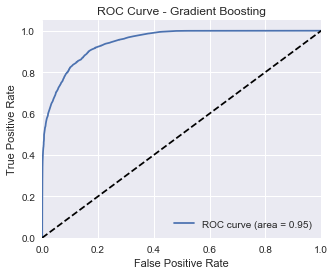

In [116]:
PredAndLabels           = gbt_result.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient Boosting Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix 

In [117]:
cm_gbt_result = gbt_result.crosstab("prediction", "label")
cm_gbt_result = cm_gbt_result.toPandas()
cm_gbt_result

,prediction_label,0,1
0,1.0,266,8294
1,0.0,63538,6451


In [118]:
#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result["1"][0]
FP = cm_gbt_result["0"][0]
TN = cm_gbt_result["0"][1]
FN = cm_gbt_result["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

Accuracy = 0.91
Sensitivity = 0.56
Specificity = 1.00
Precision = 0.97


##### Calculate Gini Coefficient from AUC

In [119]:
AUC = gbt_AUC
Gini_gbt= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_gbt)

AUC=0.95
GINI ~=0.89


##### Calculate Log Loss in pandas dataframe

In [120]:
#Create Dataframe to Calculate Log Loss
y_test= data_test.select('label')
gbt_proba=gbt_result.select('probability')

In [121]:
#Convert pyspark dataframe to numpy array
gbt_proba= np.array(gbt_proba.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
gbt_proba=gbt_proba.reshape(-1, gbt_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)

In [122]:
#Calculate log loss from Gradient Boosting
LogLoss = log_loss(y_test, gbt_proba) 

print("Log Loss Gradient Boosting:%.4f" % LogLoss)

Log Loss Gradient Boosting:0.2402


#### Gradient Boosting With Hyper-Parameter

In [ ]:
#define gradient boosting model
gbt_hyper= GBTClassifier(featuresCol="features", labelCol="label")

# Hyper-Parameter Tuning
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt_hyper.maxIter, [10])\
    .addGrid(gbt_hyper.maxDepth, [6, 7,10]) \
    .build()
crossval_gbt = CrossValidator(estimator=gbt_hyper,
                             estimatorParamMaps=paramGrid_gbt,
                             evaluator=BinaryClassificationEvaluator(),
                             numFolds=3)
#fit model to data train
gbt_model_hyper = crossval_gbt.fit(data_train)

In [ ]:
#transfrom model to data test
gbt_result_hyper = gbt_model_hyper.transform(data_test)

In [ ]:
#view id, label, prediction and probability from result of modelling
gbt_result_hyper.select('Id', 'label', 'prediction', 'probability').show(5)

#### Gradient Boosting With Hyper-Parameter Evaluation

In [ ]:
#Evaluate model by calculating accuracy and area under curve (AUC)
gbt_eval_hyper = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label")
gbt_eval_hyper2= MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label")
gbt_hyper_AUC  = gbt_eval_hyper.evaluate(gbt_result_hyper)
gbt_hyper_ACC  = gbt_eval_hyper2.evaluate(gbt_result_hyper, {gbt_eval_hyper2.metricName:"accuracy"})


print("Gradient Boosted Tree Performance Measure")
print("Accuracy = %0.2f" % gbt_hyper_ACC)
print("AUC = %.2f" % gbt_hyper_AUC)

##### ROC Grafik

In [ ]:
PredAndLabels           = gbt_result_hyper.select("probability", "label")
PredAndLabels_collect   = PredAndLabels.collect()
PredAndLabels_list      = [(float(i[0][0]), 1.0-float(i[1])) for i in PredAndLabels_collect]
PredAndLabels           = sc.parallelize(PredAndLabels_list)

metrics = BinaryClassificationMetrics(PredAndLabels)

# Area under ROC
print("Gradient Boosting Area Under ROC")
print("Area under ROC = %.2f" % metrics.areaUnderROC)

# Visualization
FPR = dict()                                                        # FPR: False Positive Rate
tpr = dict()                                                        # TPR: True Positive Rate
roc_auc = dict()
 
y_test = [i[1] for i in PredAndLabels_list]
y_score = [i[0] for i in PredAndLabels_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc="lower right")
plt.show()

##### Confusion Matrix

In [ ]:
cm_gbt_result_hyper = gbt_result_hyper.crosstab("prediction", "label")
cm_gbt_result_hyper = cm_gbt_result_hyper.toPandas()
cm_gbt_result_hyper

In [ ]:
#calculate accuracy, sensitivity, specificity and precision
TP = cm_gbt_result_hyper["1"][0]
FP = cm_gbt_result_hyper["0"][0]
TN = cm_gbt_result_hyper["0"][1]
FN = cm_gbt_result_hyper["1"][1]
Accuracy = (TP+TN)/(TP+FP+TN+FN)
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)

print ("Accuracy = %0.2f" %Accuracy )
print ("Sensitivity = %0.2f" %Sensitivity )
print ("Specificity = %0.2f" %Specificity )
print ("Precision = %0.2f" %Precision )

##### Calculate Gini Coefficient from AUC

In [ ]:
AUC = gbt_hyper_AUC
Gini_gbt_hyper= (2 * AUC -1)

print("AUC=%.2f" % AUC)
print("GINI ~=%.2f" % Gini_gbt_hyper)

##### Calculate Log Loss in pandas dataframe

In [ ]:
#Create Dataframe to Calculate Log Loss
y_test= data_test.select('label')
gbt_hyper_proba=gbt_result_hyper.select('probability')

In [ ]:
#Convert pyspark dataframe to numpy array
gbt_hyper_proba= np.array(gbt_hyper_proba.select('probability').collect())

#Convert numpy array 3 dimentional to 2 dimentional
gbt_hyper_proba=gbt_hyper_proba.reshape(-1, gbt_hyper_proba.shape[-1])

#Convert y_test dataframe to pandas dataframe
y_test=y_test.toPandas()

#Convert y_test pandas dataframe to pandas series
y_test=pd.Series(y_test['label'].values)

In [ ]:
#Calculate log loss from Gradient Boosting hyper parameter
LogLoss = log_loss(y_test, gbt_hyper_proba) 

print("Log Loss Gradient Boosting:%.4f" % LogLoss)

### Implementation Modelling to data test

#### Prediction using Logistic Regression

In [84]:
#transform logistic regression to data test
lr_predict = lr_model.transform(test2)

In [85]:
#view id, label, prediction and probability from result of modelling
lr_predict.select('Id', 'prediction', 'probability').show(5)

+-----------+----------+--------------------+
|QuoteNumber|prediction|         probability|
+-----------+----------+--------------------+
|          3|       0.0|[0.83791364398138...|
|          5|       0.0|[0.92952193248116...|
|          7|       0.0|[0.95741665141917...|
|          9|       0.0|[0.97971792414083...|
|         10|       0.0|[0.99136899854054...|
+-----------+----------+--------------------+
only showing top 5 rows



In [125]:
#select id and prediction from result of modelling and save in data frame called my_submission
my_submission=lr_predict.select("Id","prediction")

In [126]:
#convert to Pandas dataframe
my_submission=my_submission.toPandas()

In [127]:
#save to csv
my_submission.to_csv('E:/Datalabs/Classification/Home_Quote_conversion/my_submission.csv', index = False, header = True)

#### Prediction using Gradient Boosting

In [123]:
#transfrom gradient boosting model to data test
gbt_predict = gbt_model.transform(test2)

In [124]:
#view id, label, prediction and probability from result of modelling
gbt_predict.select('Id', 'prediction', 'probability').show(5)

+-----------+----------+--------------------+
|QuoteNumber|prediction|         probability|
+-----------+----------+--------------------+
|          3|       0.0|[0.92769229359160...|
|          5|       0.0|[0.90001675024220...|
|          7|       0.0|[0.90051101019602...|
|          9|       0.0|[0.91877741316781...|
|         10|       0.0|[0.80122160794555...|
+-----------+----------+--------------------+
only showing top 5 rows



In [129]:
#select id and prediction from result of modelling and save in data frame called my_submission
my_submission2=gbt_predict.select("Id","prediction")

In [130]:
#convert to Pandas dataframe
my_submission2=my_submission2.toPandas()

In [131]:
#save to csv
my_submission2.to_csv('E:/Datalabs/Classification/Home_Quote_conversion/my_submission2.csv', index = False, header = True)